# Hourly Temperature Forecasting with LSTM



---


<p align="justify">This project demonstrates how to use an LSTM (Long Short-Term Memory) neural network to forecast hourly temperatures. It utilizes the Open-Meteo API to fetch historical weather data for a specified city, prepares the data for the LSTM model, trains the model, and then generates future temperature predictions. The results are visualized and presented in a table and a plot using Gradio, creating an interactive web application.


---



## Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import gradio as gr

## Geocoding Function

In [2]:
def geocode_city(city_name: str) -> dict:
    """Get latitude, longitude, and timezone info for a city using Open-Meteo's API."""

    url = "https://geocoding-api.open-meteo.com/v1/search"
    params = {
        "name": city_name,
        "count": 1,
        "language": "en"
    }

    response = requests.get(url, params=params, timeout=15)
    response.raise_for_status()
    data = response.json()

    if not data.get("results"):
        raise ValueError("City not found. Try 'Penang', 'Singapore', 'London', etc.")

    result = data["results"][0]
    return {
        "label": f"{result['name']}, {result.get('country_code', '')}".strip(", "),
        "lat": result["latitude"],
        "lon": result["longitude"],
        "timezone": result.get("timezone", "auto"),
    }

In [3]:
geocode_city("Penang")

{'label': 'Penang, MY',
 'lat': 5.37292,
 'lon': 100.24963,
 'timezone': 'Asia/Kuala_Lumpur'}

In [4]:
# Get the latitude value
latitude = list(geocode_city("Penang").values())[1]
latitude

5.37292

In [5]:
# Get the longitude value
longitude = list(geocode_city("Kuala Lumpur").values())[2]
longitude

101.68653

In [6]:
# Get the timezone
timezone = list(geocode_city("Kuala Lumpur").values())[3]
timezone

'Asia/Kuala_Lumpur'

## Fetch Hourly Temperature

In [7]:
def fetch_hourly_temperature(lat: float, lon: float, timezone: str = "auto", past_days: int = 7) -> pd.DataFrame:
    """
    Fetch recent hourly temperature data in Celsius for the specified location.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        timezone (str): Timezone for the data (default: "auto").
        past_days (int): Number of past days to include (default: 7).

    Returns:
        pd.DataFrame: A DataFrame with two columns:
            - time: Timestamps of each hourly reading.
            - temp: Temperature values in Celsius.
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",
        "past_days": past_days,
        "forecast_days": 1,  # Include today
        "timezone": timezone,
    }

    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    data = response.json()

    times = data["hourly"]["time"]
    temps = data["hourly"]["temperature_2m"]

    df = pd.DataFrame({
        "time": pd.to_datetime(times),
        "temp": temps
    }).dropna()

    return df.reset_index(drop=True)

In [8]:
df = fetch_hourly_temperature(latitude, longitude, timezone)
df

,time,temp
0,2025-09-02 00:00:00,22.8
1,2025-09-02 01:00:00,22.6
2,2025-09-02 02:00:00,22.3
3,2025-09-02 03:00:00,22.2
4,2025-09-02 04:00:00,22.0
...,...,...
187,2025-09-09 19:00:00,26.1
188,2025-09-09 20:00:00,25.1
189,2025-09-09 21:00:00,23.7
190,2025-09-09 22:00:00,23.3


## Visualize Current Imported Data

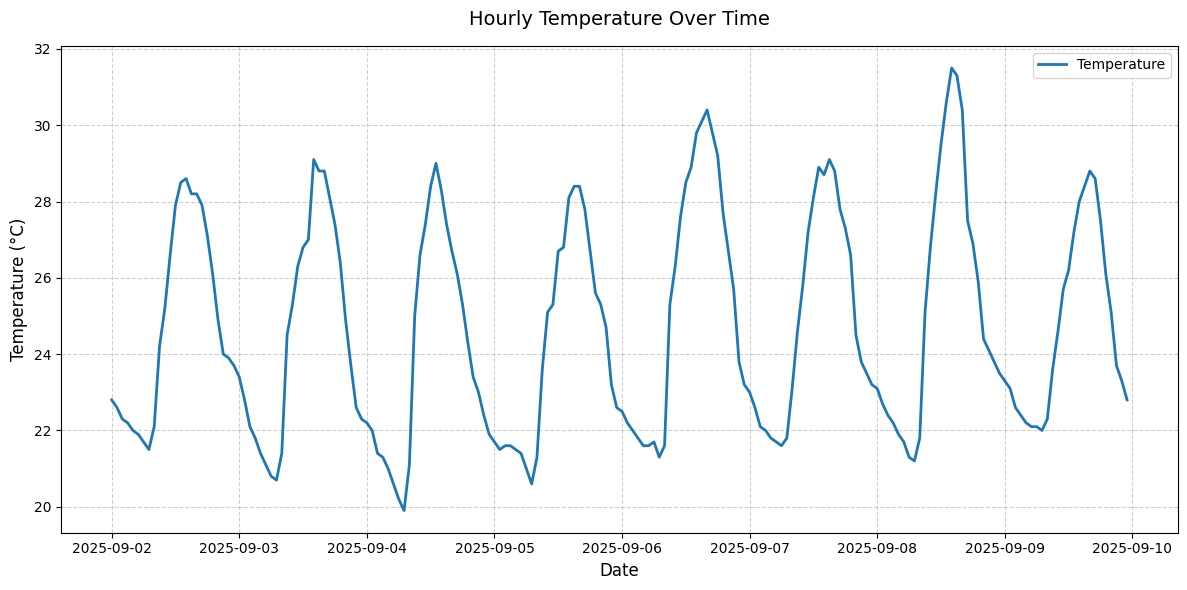

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["temp"], label="Temperature", linewidth=2)

plt.title("Hourly Temperature Over Time", fontsize=14, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Windowing Function

In [10]:
def make_windows(series: np.ndarray, window: int = 24) -> tuple[np.ndarray, np.ndarray]:
    """
    Create input/output windows from a 1D time series.

    Parameters:
        series (np.ndarray): The time series data as a 1D NumPy array.
        window (int): The number of time steps per input window (default: 24).

    Returns:
        tuple:
            - X (np.ndarray): Input sequences shaped as (samples, window, 1).
            - y (np.ndarray): Target values corresponding to each input window.
    """
    X, y = [], []

    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])

    X = np.array(X, dtype="float32")[..., np.newaxis]  # shape: (samples, window, 1)
    y = np.array(y, dtype="float32")                   # shape: (samples,)

    return X, y

## Build LSTM Model

In [11]:
# We set the window to 24 because the data has hourly intervals → 24 hours = 1 day
def build_lstm(window: int = 24) -> keras.Model:
    """
    Build and compile an LSTM model for time series forecasting.

    Parameters:
        window (int): Number of time steps in each input sequence (default: 24, one full day).

    Returns:
        keras.Model: A compiled Keras Sequential model.
    """
    model = keras.Sequential([
        layers.Input(shape=(window, 1)),   # Input shape: (24, 1) → 24 hours, 1 feature
        layers.LSTM(32),                   # LSTM layer with 32 memory units
        layers.Dense(1),                   # Output: 1 prediction for the next time step
    ])

    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model

## Train and Forecast

In [12]:
def train_and_forecast(
    temp_values: np.ndarray,
    window: int = 24,
    epochs: int = 3,
    next_step: int = 6
) -> np.ndarray:
    """
    Train an LSTM model on temperature data and forecast future values.

    Parameters:
        temp_values (np.ndarray): 1D array of temperature values.
        window (int): Number of past time steps per input sequence (default: 24).
        epochs (int): Number of training epochs (default: 3).
        next_step (int): Number of future steps to predict (default: 6).

    Returns:
        np.ndarray: Predicted temperature values (in Celsius).
    """
    # Reshape values for scaling
    vals = temp_values.reshape(-1, 1)

    # Scale data using MinMaxScaler
    scaler = MinMaxScaler()
    vals_scaled = scaler.fit_transform(vals)

    # Create supervised sequences (X, y)
    X, y = make_windows(vals_scaled, window=window)

    # Build and train the LSTM model
    model = build_lstm(window)
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)

    # Start with the latest window for prediction
    last_window = vals_scaled[-window:].copy()
    pred_scaled = []

    for _ in range(next_step):
        # Predict next step
        pred = model.predict(last_window.reshape(1, window, 1), verbose=0)[0, 0]

        # Save prediction
        pred_scaled.append(pred)

        # Update window: drop oldest value, add new prediction
        last_window = np.append(last_window[1:], pred)

    # Rescale predictions back to Celsius
    preds = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()

    return preds

In [13]:
train_and_forecast(df['temp'].values)

array([26.046911, 26.059824, 26.112907, 26.171246, 26.232548, 26.295778],
      dtype=float32)

## Make Plot

In [14]:
# Plotting Function: Compare actual vs. forecasted temperatures
def make_plot(
    df: pd.DataFrame,
    future_vals: np.ndarray,
    future_times: pd.DatetimeIndex,
    window: int = 24
) -> plt.Figure:
    """
    Plot recent actual temperatures against future predictions.

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['time', 'temp'] containing past data.
        future_vals (np.ndarray): Forecasted temperature values.
        future_times (pd.DatetimeIndex): Timestamps corresponding to forecasts.
        window (int): Window size used for training, influences history length shown.

    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    # Select recent history (at least 24, or 3×window points)
    tail = df.tail(max(24, 3 * window)).copy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot actual and forecasted values
    ax.plot(tail["time"], tail["temp"].values, label="Actual (recent)")
    ax.plot(future_times, future_vals, marker="o", label="Forecast (next)")

    # Labels and title
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title("Hourly Temperature: Actual vs Forecast")
    ax.legend()

    # Format datetime ticks
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()

    plt.tight_layout()
    return fig

## Create Gradio App

In [15]:
# App Runner Function
DEFAULT_CITY = "Penang"
WINDOW = 24
EPOCHS = 3
PAST_DAYS = 7

def run_app(city: str, next_step: int) -> tuple[str, plt.Figure | None, pd.DataFrame]:
    """
    Run the forecasting workflow for a given city.

    Parameters:
        city (str): City name to geocode and fetch weather data for.
        next_step (int): Number of future hours to forecast.

    Returns:
        tuple:
            - subtitle (str): Information about the run (city, days, window, epochs).
            - fig (plt.Figure | None): Matplotlib figure showing actual vs. forecast temps.
            - out_table (pd.DataFrame): Forecast table with timestamps and predicted temps.
    """
    try:
        # Step 1: Get city information
        geo = geocode_city(city)

        # Step 2: Fetch recent hourly temperature data
        df = fetch_hourly_temperature(
            geo["lat"],
            geo["lon"],
            timezone=geo["timezone"],
            past_days=PAST_DAYS
        )

        # Step 3: Train model and generate forecasts
        preds = train_and_forecast(
            df["temp"].values,
            window=WINDOW,
            epochs=EPOCHS,
            next_step=next_step
        )

        # Step 4: Create future time index
        future_times = pd.date_range(
            start=df["time"].iloc[-1] + pd.Timedelta(hours=1),
            periods=next_step,
            freq="H"
        )
        # Example: if last record is 2025-08-21 14:00 and next_step=3 →
        # future times = [15:00, 16:00, 17:00]

        # Step 5: Build plot
        fig = make_plot(df, preds, future_times, window=WINDOW)

        # Step 6: Create forecast table
        out_table = pd.DataFrame({
            "time": future_times,
            "forecast_temp_C": np.round(preds, 2)
        })

        # Step 7: Create subtitle
        subtitle = (
            f"City resolved to: {geo['label']} • "
            f"Using last {PAST_DAYS} days • "
            f"Window={WINDOW} • Epochs={EPOCHS}"
        )

        return subtitle, fig, out_table

    except Exception as e:
        return f"Error: {e}", None, pd.DataFrame()

/tmp/ipython-input-782075297.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(


('City resolved to: Penang, MY • Using last 7 days • Window=24 • Epochs=3',
 <Figure size 1000x600 with 1 Axes>,
                  time  forecast_temp_C
 0 2025-09-10 00:00:00        27.250000
 1 2025-09-10 01:00:00        27.360001
 2 2025-09-10 02:00:00        27.430000
 3 2025-09-10 03:00:00        27.450001
 4 2025-09-10 04:00:00        27.450001
 5 2025-09-10 05:00:00        27.430000)

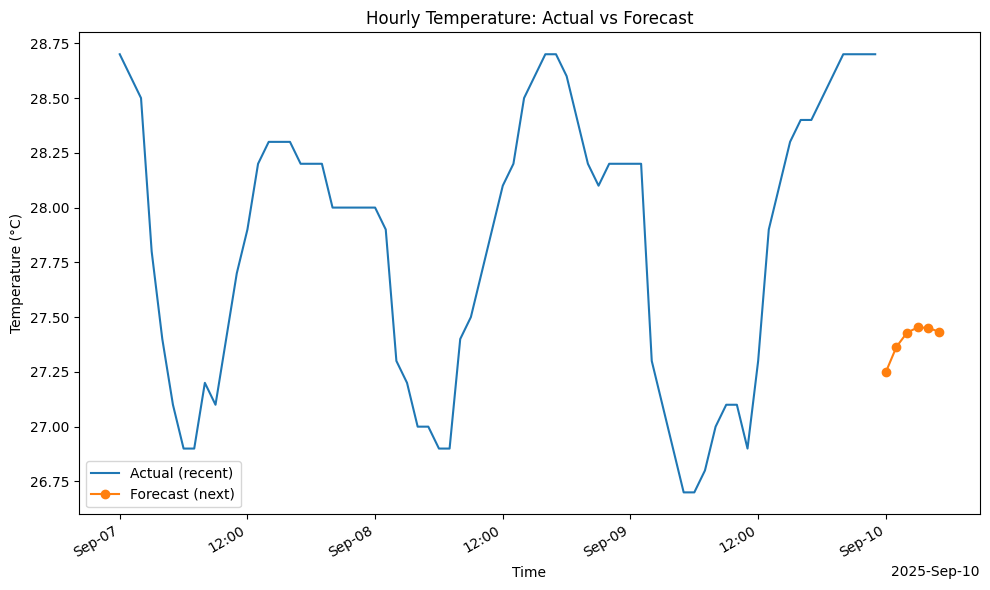

In [16]:
run_app("Penang", 6)

In [17]:
# Default city
DEFAULT_CITY = "Penang"

# Build the Gradio interface
demo = gr.Interface(
    fn=run_app,
    inputs=[
        gr.Textbox(
            label="City",
            value=DEFAULT_CITY,
            placeholder="Enter a city name...",
        ),
        gr.Slider(
            minimum=1,
            maximum=24,
            value=6,
            step=1,
            label="Hours to Predict",
        ),
    ],
    outputs=[
        gr.Markdown(label="Info"),
        gr.Plot(label="Actual vs Forecast"),
        gr.DataFrame(label="Predicted Next Hours"),
    ],
    title="Simple LSTM Forecast (Live Data)",
    description="Enter a city, choose how many hours to predict, then click Submit.",
)

In [18]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2dda04002253796a53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusion

<p align="justify">This project successfully demonstrates the application of an LSTM model for hourly temperature forecasting using live weather data. The integration with the Open-Meteo API allows for dynamic data retrieval, and the Gradio interface provides an intuitive way to interact with the forecasting model and visualize the results. This approach can be extended and refined for other time series forecasting tasks and the development of more complex predictive models.